# 06_ZTM_PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the paramters of what one model has learned on another dataset adn applying to our problems.

* Pretrained model = Foundational models

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


Now we've got version of torch and torchvision version, we're after, let's import the code we've written in previous sections so that we don't have to write it all again.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.33 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
!nvidia-smi

Sun Apr 28 14:35:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

We need our pizza, steak and sushi data to build a transfer learning model on.

In [20]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi' # Images from a subset of classes from the Food101 dataset

# If the image folder doesn't exists, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory exists, skipping re-download')

else:
  print(f"Did not find {image_path} downloading it...")
  image_path.mkdir(parents = True,
                   exist_ok = True)

  # Download the pizza_steak_sushi data
  with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza steak sushi data
  with zipfile.ZipFile(data_path /'pizza_steak_sushi.zip', 'r') as zipref:
    print('Unzipping pizza, steak, sushi data...')
    zipref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path /'pizza_steak_sushi.zip')

Did not find data/pizza_steak_sushi downloading it...
Unzipping pizza, steak, sushi data...


In [21]:
# Setup directory path
train_dir = image_path/'train'
test_dir = image_path/'test'

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we make in 05. PyTorch going modular.

There's one thging we have to think about when loading : How to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:
1. Manually created transforms - your define what transforms you want your data to go through
2. Automaticaaly created transforms - The transforms of your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that your pass through it is **transformed** in the same way that the data the model was trained on.


### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),

In [24]:
from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std  = [0.229, 0.224, 0.225])

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
                                        transforms.ToTensor(), # 2. Turn image values to between 0 & 1
                                        normalize]) # Make sure images have same distributions as ImageNet where our pretrained models have been trained on

In [26]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a32bc86aa10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto_creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.'

In [27]:
import torchvision

# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'DEFAULT' = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [30]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [32]:
# Create DataLoaders using automatic transforms
train_dataloader, test_loader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                           test_dir = test_dir,
                                                                           transform = auto_transforms,
                                                                           batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a31bd6d7b50>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get pretrained model:
1. PyTorch domain libraries
2. Libraries like tim (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)


### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed: How fast it runs?
2. Size -How big is the model?
3. Performance: How well does it work on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

or does it live on a server ?

Looking at https://pytorch.org/vision/stable/models.html

Whcih model should we chose?

For our case(deploying foodvision mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of The Bitter Lesson, if has infinite compute, we'd likely pick the bigeest model + most parameters + most general we could. http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0.(backbone)

In [66]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained = True)

# NEW method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT: for best available weights
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Model before classfication layer will simply extract features from the data. The classifier layer or top layer (classification head) will compress all the learnt features into the desired output shape. Hence, we freeze the feature extraction layers and customize teh classfier (output_head) as per our requirements.

In [67]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`



In [68]:
# Print with torchinfo
from torchinfo import summary
summary(model = model,
        input_size = (1,3,224,224), # example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our need

With feature extraction model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [69]:
# Freeze all of the base layers in EffNetB0
for params in model.features.parameters(): # They have requires_grad = True which means they are trainable
  # print(params)
  params.requires_grad = False # Its going to freeze all of the parameters()

In [70]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [71]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, # feature vector coming in
              out_features = len(class_names))
)

In [72]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [73]:
# Print with torchinfo
from torchinfo import summary
summary(model = model,
        input_size = (1,3,224,224), # example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train Model

In [74]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.01)

In [75]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save  the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8426 | train_acc: 0.6562 | test_loss: 0.5284 | test_acc: 0.7424
Epoch: 2 | train_loss: 0.5781 | train_acc: 0.7266 | test_loss: 0.2950 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.2589 | train_acc: 0.9102 | test_loss: 0.4332 | test_acc: 0.7756
Epoch: 4 | train_loss: 0.4218 | train_acc: 0.8516 | test_loss: 0.2406 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.5398 | train_acc: 0.7734 | test_loss: 0.4328 | test_acc: 0.8258
[INFO] Total training time: 11.832 seconds


## 5. Evaluate model by plotting loss curves

failed


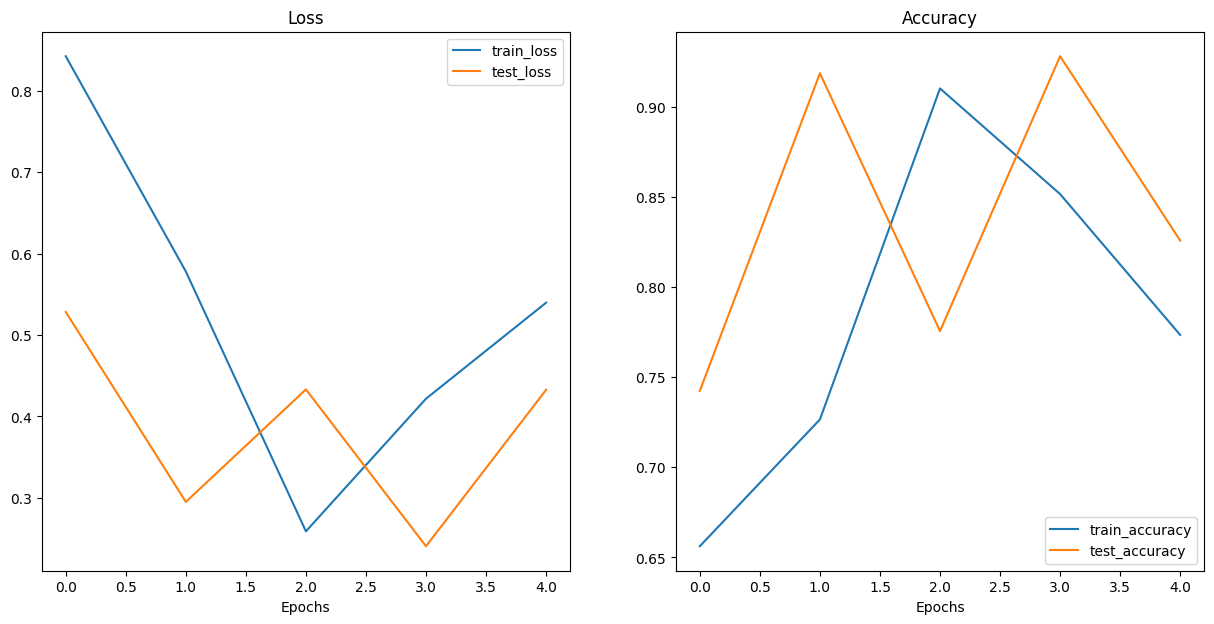

In [77]:
try:
  from helper_functions import plot_loss_curves
  print('failed')
except:
  print(f"[INFO] Couldn't find helper_functions.py failed the try")
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py')
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motti of *visualize, visualize, visualize*!

And make some qualitatibe predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same datatype
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data ideally, you will transform your test data and custom data the same

TO do all of this automagically, let's create a function called `pred_and_plot_image()`.

1. Take in a trained model, a list of class names, a filepath to a target image, an image side, a transform and a target device
2. Open the image with `PIL.Image.open()`
3. CReate a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it is ready for inference
(this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure it's dimensionality is suited for the model(this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's predcition probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplitlob` and get the title to the prediction label from step 9 and prediction probability from step 9.

In [79]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

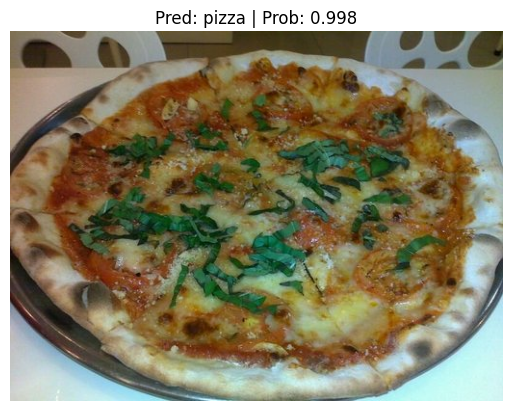

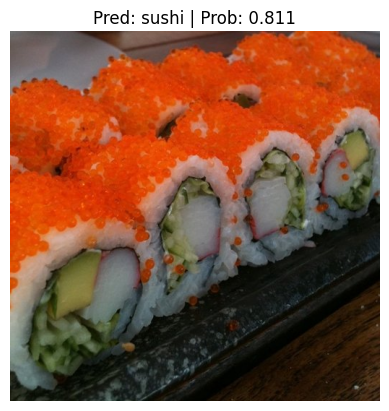

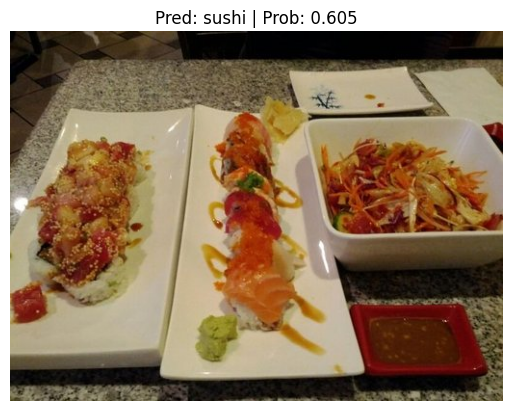

In [82]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

Let's make a prediction on the pizza dad image.

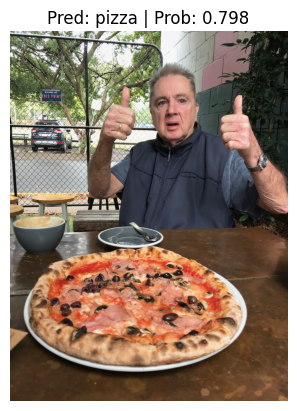

In [84]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)